# Machine learning with TensorFlow: CNN

Date: November 20, 2018

Neural network: convolution, fully-connected and softmax

Classification of human body motion:
- walking
- sitting down
- turning right while walking
- turning left while walking

In [12]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as sg
import serial
import time
import random

## Preparing data set for training CNN

In [13]:
SAMPLE_NUMS = 260  # per sec
SAMPLING_RATE = 80.0  # Hz
GYRO_RESOLUTION = 250.0 / 32768.0
ACCEL_RESOLUTION = 2.0 / 32768.0

TRAINING_SET = [['./20180821_walking_straight.csv', 0],
               ['./20180821_sitting.csv', 1],
               ['./20180821_turning_left.csv', 2],
               ['./20180821_turning_right.csv', 3],                
               ['./20180823_walking_straight.csv', 0],
               ['./20180823_sitting.csv', 1],
               ['./20180823_turning_left.csv', 2],
               ['./20180823_turning_right.csv', 3]]

TEST_SET = [['./20180822_walking_straight.csv', 0],
            ['./20180822_sitting.csv', 1],
            ['./20180822_turning_left.csv', 2],
            ['./20180822_turning_right.csv', 3]]

TIME_INTERVAL = 260.0 / SAMPLING_RATE  # sec

MEASUREMENTS = 8
RECORDS = 260

In [14]:
gres = lambda v: v * GYRO_RESOLUTION
ares = lambda v: v * ACCEL_RESOLUTION
to_time = lambda v: v / SAMPLING_RATE

def conv(df, lpf=False):
    df[['gx', 'gy', 'gz']] = df[['gx', 'gy', 'gz']].apply(gres)
    df[['ax', 'ay', 'az']] = df[['ax', 'ay', 'az']].apply(ares)
    if lpf:
        CUTOFF = 10.0
        b, a = sg.butter(5, CUTOFF/SAMPLING_RATE, btype='low')
        df[['ax', 'ay', 'az']] = df[['ax', 'ay', 'az']].apply(lambda row: sg.lfilter(b, a, row))
        CUTOFF = 10.0
        b, a = sg.butter(5, CUTOFF/SAMPLING_RATE, btype='low')
        df[['gx', 'gy', 'gz']] = df[['gx', 'gy', 'gz']].apply(lambda row: sg.lfilter(b, a, row))
    df[['cnt']] = df[['cnt']].apply(to_time)
    df.set_index('cnt', drop=True, inplace=True)

In [15]:
training_set = []
test_set = []

for file, l in TRAINING_SET:
    df = pd.read_csv(file, dtype=np.int16)
    conv(df, lpf=True)
    for i in range(MEASUREMENTS):
        training_set.append([df[df['id']==i], l])
        
for file, l in TEST_SET:
    df = pd.read_csv(file, dtype=np.int16)
    conv(df, lpf=True)
    for i in range(MEASUREMENTS):
        test_set.append([df[df['id']==i], l])
    
random.shuffle(training_set)
random.shuffle(test_set)

In [16]:
# use accel x axis and gyro z axis values for classification of human body motion
train_x, train_t = [], []
test_x, test_t = [], []
for df, label in training_set:
    values = []
    for index, item in df.iterrows():
        values.append([item['ax'],item['ay'],item['az'],item['gx'],item['gy'],item['gz']])
    train_x.append(values)
    train_t.append(label)
for df, label in test_set:
    values = []
    for index, item in df.iterrows():
        values.append([item['ax'],item['ay'],item['az'],item['gx'],item['gy'],item['gz']])                     
    test_x.append(values)
    test_t.append(label)

In [17]:
from keras.utils import to_categorical

train_labels=to_categorical(train_t)
test_labels=to_categorical(test_t)

train_data = np.array(train_x)
test_data = np.array(test_x)

train_data.shape

(64, 260, 6)

## Keras/TensorFlow

In [18]:
num_samples = 260
num_classes = 4
num_layers = 6

In [19]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Conv1D(4, 12, activation='relu', input_shape=(num_samples, num_layers)))
model.add(layers.MaxPooling1D(2))

model.add(layers.Conv1D(8, 12, activation='relu'))
model.add(layers.MaxPooling1D(2))

model.add(layers.Conv1D(16, 12, activation='relu'))
model.add(layers.MaxPooling1D(2))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 249, 4)            292       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 124, 4)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 113, 8)            392       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 56, 8)             0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 45, 16)            1552      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 22, 16)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 352)               0         
__________

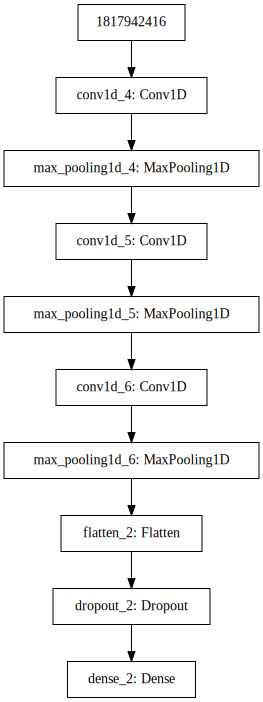

In [20]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [21]:
EPOCHS = 30
history = model.fit(train_data, train_labels, epochs=EPOCHS, validation_data=(test_data, test_labels), batch_size=10)

Train on 64 samples, validate on 32 samples
Epoch 1/30
64/64 [==============================] - 4s 55ms/step - loss: 3.8112 - acc: 0.3750 - val_loss: 1.8127 - val_acc: 0.2813
Epoch 2/30
64/64 [==============================] - 0s 6ms/step - loss: 2.5595 - acc: 0.2656 - val_loss: 1.2054 - val_acc: 0.4375
Epoch 3/30
64/64 [==============================] - 0s 7ms/step - loss: 2.0510 - acc: 0.4375 - val_loss: 1.1341 - val_acc: 0.4375
Epoch 4/30
64/64 [==============================] - 0s 5ms/step - loss: 1.2303 - acc: 0.5625 - val_loss: 0.8359 - val_acc: 0.5938
Epoch 5/30
64/64 [==============================] - 0s 6ms/step - loss: 1.1510 - acc: 0.6094 - val_loss: 0.7354 - val_acc: 0.6875
Epoch 6/30
64/64 [==============================] - 0s 6ms/step - loss: 0.9110 - acc: 0.6406 - val_loss: 0.6366 - val_acc: 0.6875
Epoch 7/30
64/64 [==============================] - 0s 6ms/step - loss: 0.8491 - acc: 0.6563 - val_loss: 0.5721 - val_acc: 0.7812
Epoch 8/30
64/64 [===========================

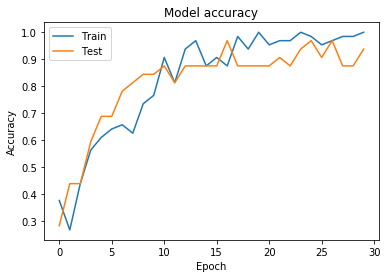

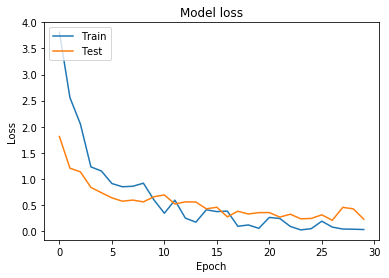

In [22]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()